# Logistic Regression Pipeline for A549 (GREG)

This notebook assesses variaegated implementations of the logistic regression models for the data dervied from the A549 cell-line in GREG.

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [1]:
requiredPackages <- c("glmnet", "rms", "caret", "e1071", "ROSE", "DMwR", "BiocManager", "ROCR")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages, dependencies = TRUE)

library(glmnet)
library(rms)
library(caret)
library(e1071)
library(ROSE)
library(DMwR)
library(ROCR)

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster



Attaching package: ‘e1071’


The following object is masked from ‘package:Hmisc’:

    impute


Loaded ROSE 0.0-3


Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### <a id=link2>2. Loading Data </a>

In [2]:
a549gregStandard <- read.table("../data/A549forML.txt", header = TRUE) ## loading full data
a549greg <- a549gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(a549greg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
2,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
3,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
4,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
5,0,0,0.00000000,0.00000000,0.00000,0,0.00000000,0.000000,0.00000000,0.0000000,0.00000000,0.00000000,Non-Hub
6,0,0,0.02727825,0.02613314,1.58534,0,0.03331304,1.537907,0.02891425,0.1631014,0.06050439,0.05796767,Non-Hub


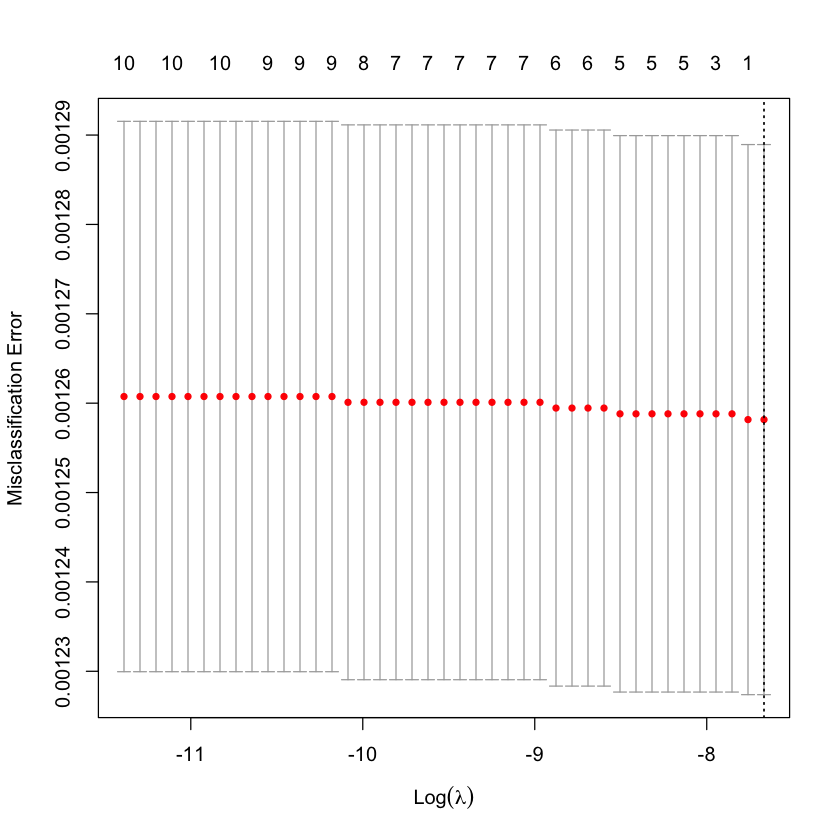

In [4]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(a549greg[,1:12]),
                         a549greg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 100)


plot(cv.modelfit)

In [5]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 41 lambda values in all:
 0.0004680186 0.0004264411 0.0003885573 0.0003540389 0.0003225871 0.0002939293 0.0002678174 0.0002440253 0.0002223468 0.0002025941 0.0001845962 0.0001681972 0.000153255 0.0001396402 0.000127235 0.0001159318 0.0001056327 9.62486e-05 8.769814e-05 7.990728e-05 7.280854e-05 6.634043e-05 6.044693e-05 5.507699e-05 5.01841e-05 4.572588e-05 4.166372e-05 3.796243e-05 3.458995e-05 3.151708e-05 2.871719e-05 2.616603e-05 2.384151e-05 2.17235e-05 1.979364e-05 1.803523e-05 1.643303e-05 1.497317e-05 1.364299e-05 1.243098e-05 1.132665e-05 
, out of which 1.132665e-05 is the minimum, while 0.0004680186 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [6]:
set.seed(2)
modelfit <- glmnet(as.matrix(a549greg[,1:12]),
                   a549greg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = min(cv.modelfit$lambda))

# Listing non-zero coefficients
print(modelfit$beta[,1])

        CTCF        EP300     H3K27me3     H3K36me3      H3K4me1      H3K4me2 
-0.085831339 -0.044517940 -0.044367058 -0.170825653 -0.021758567 -0.020956371 
     H3K4me3       H3K9ac      H3K9me3        RAD21      RNAPol2          YY1 
 0.000000000 -0.004894414  0.024193190  0.055130404  0.000000000 -0.003314569 


In [7]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)         CTCF        EP300     H3K27me3     H3K36me3      H3K4me1 
 6.920308396 -0.085831339 -0.044517940 -0.044367058 -0.170825653 -0.021758567 
     H3K4me2      H3K4me3       H3K9ac      H3K9me3        RAD21      RNAPol2 
-0.020956371  0.000000000 -0.004894414  0.024193190  0.055130404  0.000000000 
         YY1 
-0.003314569

13 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  6.920308396
CTCF        -0.085831339
EP300       -0.044517940
H3K27me3    -0.044367058
H3K36me3    -0.170825653
H3K4me1     -0.021758567
H3K4me2     -0.020956371
H3K4me3      .          
H3K9ac      -0.004894414
H3K9me3      0.024193190
RAD21        0.055130404
RNAPol2      .          
YY1         -0.003314569

In [4]:
set.seed(5) # for reproducibility of results.
a549greg$Class <- as.numeric(as.factor(a549greg$Class))-1
part <- sample(2, nrow(a549greg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- a549greg[part==1,]
test <- a549greg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

a549model <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(a549model)

So, now we have 1084135 training rows and 464157 testing rows


Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8513   0.0448   0.0472   0.0502   1.3138  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.945139   0.038536 180.226  < 2e-16 ***
CTCF        -0.080417   0.022269  -3.611 0.000305 ***
EP300       -0.039099   0.015741  -2.484 0.012994 *  
H3K27me3    -0.052015   0.027513  -1.891 0.058685 .  
H3K36me3    -0.166691   0.026401  -6.314 2.72e-10 ***
H3K4me1     -0.023648   0.005652  -4.184 2.87e-05 ***
H3K4me2     -0.032906   0.015826  -2.079 0.037601 *  
H3K4me3      0.014759   0.016058   0.919 0.358045    
H3K9ac      -0.007253   0.002725  -2.662 0.007769 ** 
H3K9me3      0.055458   0.026233   2.114 0.034508 *  
RAD21        0.041308   0.021226   1.946 0.051637 .  
RNAPol2      0.009738   0.007939   1.227 0.219951    
YY1         -0.025635   0.029218  -0.877 0.380282    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 

In [9]:
vif(a549model)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
2.385418 2.244290 1.180298 1.649650 1.647591 6.047705 7.149076 2.084489 
 H3K9me3    RAD21  RNAPol2      YY1 
1.681026 3.558199 2.301632 3.079734

We can remove **H3K4me3** due to its high *p* and VIF values, and then re-evaluate the model.

In [9]:
a549model1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNAPol2 + YY1,
               data = train,
               family = "binomial")
summary(a549model1)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNAPol2 + YY1, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8483   0.0448   0.0472   0.0502   1.3156  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.944837   0.038529 180.248  < 2e-16 ***
CTCF        -0.081991   0.022114  -3.708 0.000209 ***
EP300       -0.045170   0.013869  -3.257 0.001126 ** 
H3K27me3    -0.051975   0.027555  -1.886 0.059264 .  
H3K36me3    -0.167965   0.026349  -6.375 1.83e-10 ***
H3K4me1     -0.025231   0.005347  -4.719 2.37e-06 ***
H3K4me2     -0.021358   0.009940  -2.149 0.031654 *  
H3K9ac      -0.006390   0.002511  -2.545 0.010919 *  
H3K9me3      0.057326   0.026136   2.193 0.028279 *  
RAD21        0.042420   0.021190   2.002 0.045293 *  
RNAPol2      0.012610   0.007488   1.684 0.092172 .  
YY1         -0.018612   0.029114  -0.639 0.522645 

In [10]:
vif(a549model1)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2   H3K9ac  H3K9me3 
2.352661 1.803314 1.181562 1.652170 1.483834 2.393071 1.771680 1.670347 
   RAD21  RNAPol2      YY1 
3.527989 2.006369 2.985672

In [11]:
yTrain <- predict(a549model1, train, type = "response")
head(yTrain)

1         2         4         5         7        10 
0.9990373 0.9990373 0.9990373 0.9990373 0.9989984 0.9990197

In [12]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0.0000000,0,0,0.0000000,0,0,0.00000000,0,1
2,0,0,0,0,0.0000000,0,0,0.0000000,0,0,0.00000000,0,1
4,0,0,0,0,0.0000000,0,0,0.0000000,0,0,0.00000000,0,1
5,0,0,0,0,0.0000000,0,0,0.0000000,0,0,0.00000000,0,1
7,0,0,0,0,1.3254480,0,0,1.0985050,0,0,0.06050439,0,1
10,0,0,0,0,0.5457727,0,0,0.6957198,0,0,0.00000000,0,1


The confusion matrix is
         Actual
Predicted      0      1
        0      0      2
        1    626 463529
The misclassification error of the model is 0.135299 % 
The sensitivity of the model is 0 % 
The specificity of the model is 99.99957 % 
The area under curve is 0.4999978 
The statistical significance for the model is 5.07764e-30 
The confidence level for the model is 100 %

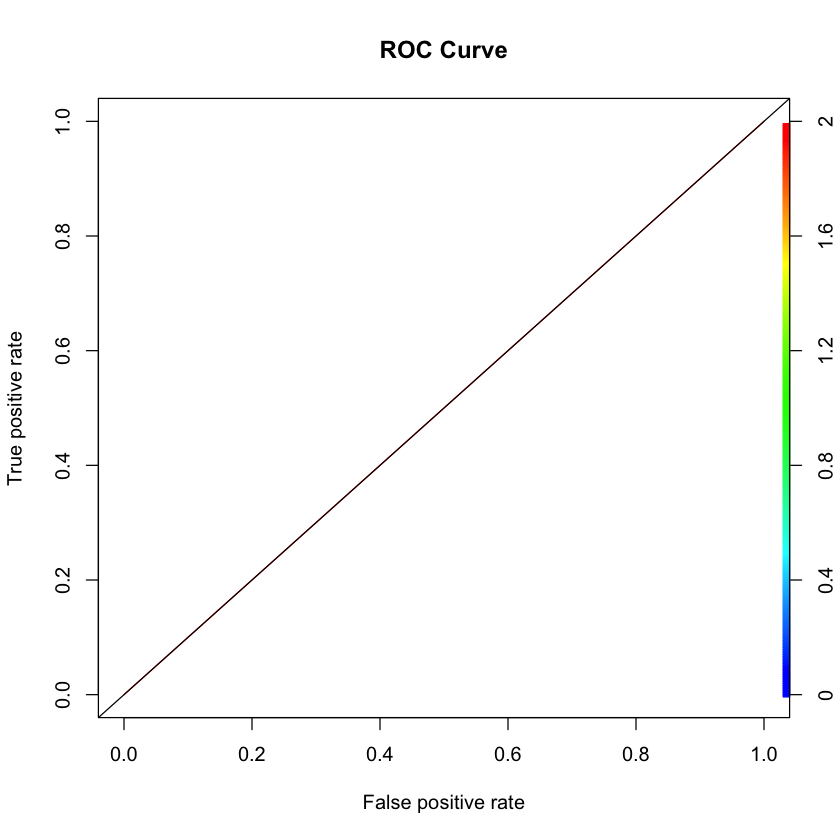

In [16]:
source("modelPerformance.R")
modelPerformance(a549model1, test, test$Class)

We can clearly observe that the model has **zero sensitivity** and **high specificity**. It means that the model is highly biased towards the non-hubs and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (0: hubs).

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [17]:
table(a549greg$Class)


      0       1 
   1948 1546344 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [18]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1546344)$data

In [19]:
table(overTrain$Class)


      0       1 
 463531 1082813 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [20]:
a549modelOver <- glm(formula = Class ~ .,
               data = overTrain,
               family = "binomial")
summary(a549modelOver)


Call:
glm(formula = Class ~ ., family = "binomial", data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7119  -1.3898   0.7527   0.8283   5.7186  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.1900021  0.0028709 414.507  < 2e-16 ***
CTCF        -0.1037898  0.0021456 -48.374  < 2e-16 ***
EP300       -0.0894459  0.0025340 -35.299  < 2e-16 ***
H3K27me3    -0.0617760  0.0018740 -32.964  < 2e-16 ***
H3K36me3    -0.1958172  0.0022262 -87.958  < 2e-16 ***
H3K4me1     -0.0697975  0.0009609 -72.634  < 2e-16 ***
H3K4me2     -0.0011264  0.0014249  -0.790    0.429    
H3K4me3     -0.0018112  0.0013278  -1.364    0.173    
H3K9ac      -0.0028234  0.0003052  -9.251  < 2e-16 ***
H3K9me3      0.0809401  0.0018890  42.849  < 2e-16 ***
RAD21        0.0405544  0.0022433  18.078  < 2e-16 ***
RNAPol2      0.0046683  0.0006248   7.472 7.89e-14 ***
YY1         -0.0332399  0.0032094 -10.357  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.

In [21]:
vif(a549modelOver)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
2.606187 2.612380 1.102745 1.316102 1.691790 5.016748 6.461400 1.703307 
 H3K9me3    RAD21  RNAPol2      YY1 
1.374102 3.304306 2.217252 3.091552

Reorienting the model after omitting **H3K4me3**.

In [22]:
a549modelOver1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNAPol2 + YY1,
               data = overTrain,
               family = "binomial")
summary(a549modelOver1)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNAPol2 + YY1, family = "binomial", 
    data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7121  -1.3891   0.7527   0.8282   5.7096  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.1900348  0.0028708 414.527  < 2e-16 ***
CTCF        -0.1038926  0.0021449 -48.437  < 2e-16 ***
EP300       -0.0884253  0.0024191 -36.553  < 2e-16 ***
H3K27me3    -0.0617209  0.0018736 -32.942  < 2e-16 ***
H3K36me3    -0.1955430  0.0022174 -88.186  < 2e-16 ***
H3K4me1     -0.0694715  0.0009308 -74.638  < 2e-16 ***
H3K4me2     -0.0025166  0.0009957  -2.528   0.0115 *  
H3K9ac      -0.0029623  0.0002880 -10.288  < 2e-16 ***
H3K9me3      0.0806244  0.0018747  43.007  < 2e-16 ***
RAD21        0.0407332  0.0022402  18.183  < 2e-16 ***
RNAPol2      0.0042352  0.0005378   7.875  3.4e-15 ***
YY1         -0.0345962  0.0030552 

In [23]:
vif(a549modelOver1)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2   H3K9ac  H3K9me3 
2.603948 2.382385 1.102296 1.305504 1.586448 2.447300 1.513217 1.353474 
   RAD21  RNAPol2      YY1 
3.294058 1.642672 2.798120

The confusion matrix is
         Actual
Predicted      0      1
        0     46   9885
        1    580 453646
The misclassification error of the model is 2.254625 % 
The sensitivity of the model is 7.348243 % 
The specificity of the model is 97.86746 % 
The area under curve is 0.5260785 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

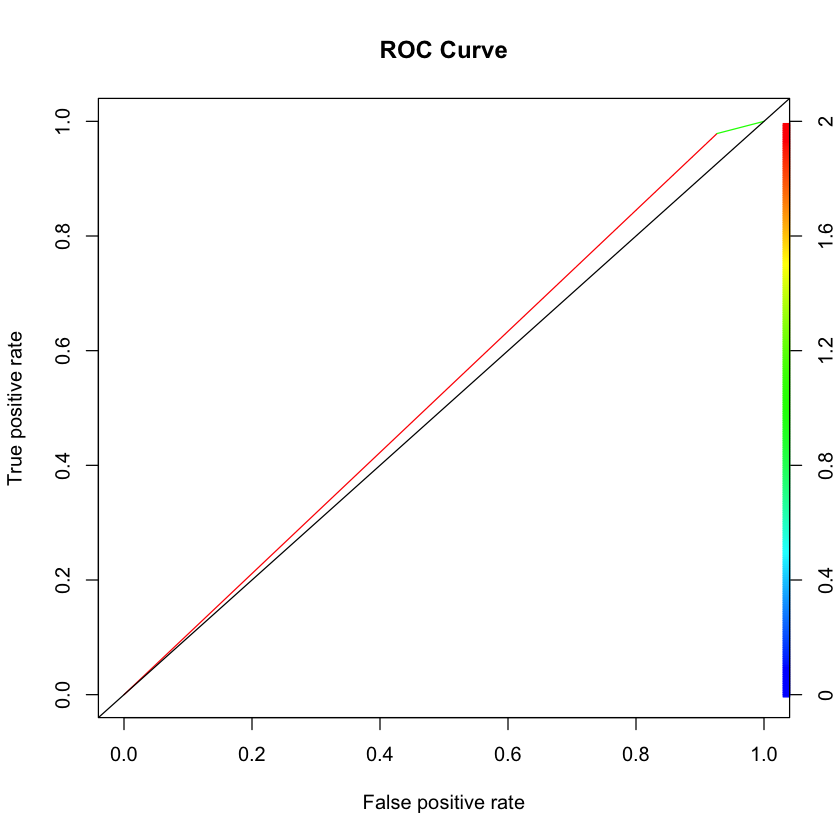

In [24]:
modelPerformance(a549modelOver1, test, test$Class)

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [25]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N= 2644)$data
table(underTrain$Class)


   0    1 
1322 1322 

In [26]:
a549modelUnder <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2
+ YY1 ,
               data = underTrain,
               family = "binomial")
summary(a549modelUnder)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2 + 
    YY1, family = "binomial", data = underTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5084  -1.1839   0.3944   1.1118   2.9175  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.415998   0.067652   6.149 7.79e-10 ***
CTCF        -0.171784   0.062696  -2.740  0.00614 ** 
EP300       -0.148681   0.086018  -1.728  0.08390 .  
H3K27me3    -0.014029   0.042534  -0.330  0.74153    
H3K36me3    -0.173686   0.057303  -3.031  0.00244 ** 
H3K4me1     -0.055712   0.024085  -2.313  0.02072 *  
H3K4me2      0.017820   0.035143   0.507  0.61210    
H3K4me3      0.020345   0.035752   0.569  0.56933    
H3K9ac      -0.006087   0.009634  -0.632  0.52745    
H3K9me3      0.124494   0.042987   2.896  0.00378 ** 
RAD21        0.131537   0.060373   2.179  0.02935 *  
RNAPol2     -0.013806   0.018171  -

The confusion matrix is
         Actual
Predicted      0      1
        0    322 141911
        1    304 321620
The misclassification error of the model is 30.63942 % 
The sensitivity of the model is 51.4377 % 
The specificity of the model is 69.38479 % 
The area under curve is 0.6041124 
The statistical significance for the model is 4.326143e-19 
The confidence level for the model is 100 %

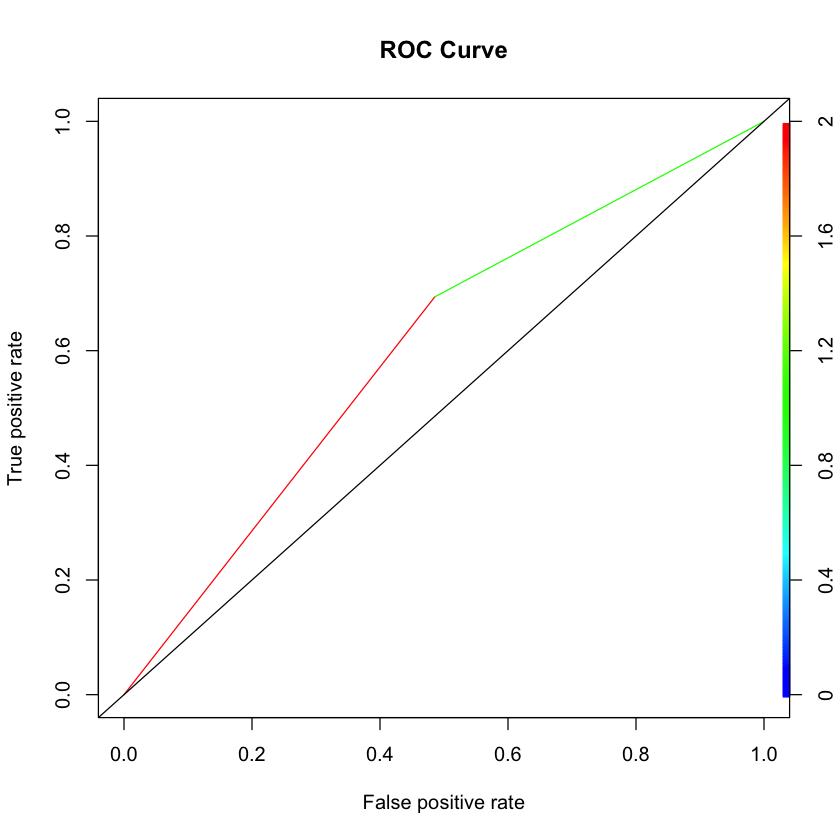

In [27]:
modelPerformance(a549modelUnder, test, test$Class)

This case is quite balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [5]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.

train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 100000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
1323322 1322000 

In [6]:
a549modelSMOTE <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2
+ YY1 ,
               data = smoteData,
               family = "binomial")
summary(a549modelSMOTE)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2 + 
    YY1, family = "binomial", data = smoteData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4205  -1.1863  -0.2397   1.1206   6.0125  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.3562896  0.0020705  172.076  < 2e-16 ***
CTCF        -0.1218396  0.0018495  -65.878  < 2e-16 ***
EP300       -0.1041659  0.0024349  -42.781  < 2e-16 ***
H3K27me3    -0.0616899  0.0013659  -45.166  < 2e-16 ***
H3K36me3    -0.2148586  0.0017527 -122.586  < 2e-16 ***
H3K4me1     -0.0780517  0.0007878  -99.071  < 2e-16 ***
H3K4me2      0.0093059  0.0011877    7.836 4.67e-15 ***
H3K4me3     -0.0030035  0.0011353   -2.646  0.00815 ** 
H3K9ac      -0.0028876  0.0002698  -10.702  < 2e-16 ***
H3K9me3      0.1034492  0.0013833   74.786  < 2e-16 ***
RAD21        0.0637778  0.0019908   32.036  < 2e-16 ***
RNAPol2     

Let us now examine this model with the test data.

In [8]:
vif(a549modelSMOTE)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
2.804929 3.172623 1.125689 1.397842 1.725700 5.509012 7.370747 1.862558 
 H3K9me3    RAD21  RNAPol2      YY1 
1.434863 3.692689 2.156437 3.714707

The confusion matrix is
         Actual
Predicted      0      1
        0    324 141626
        1    302 321905
The accuracy of the model is 69.42242 % 
The misclassification error of the model is 30.57758 % 
The sensitivity of the model is 51.75719 % 
The specificity of the model is 69.44627 % 
The area under curve is 0.6060173 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

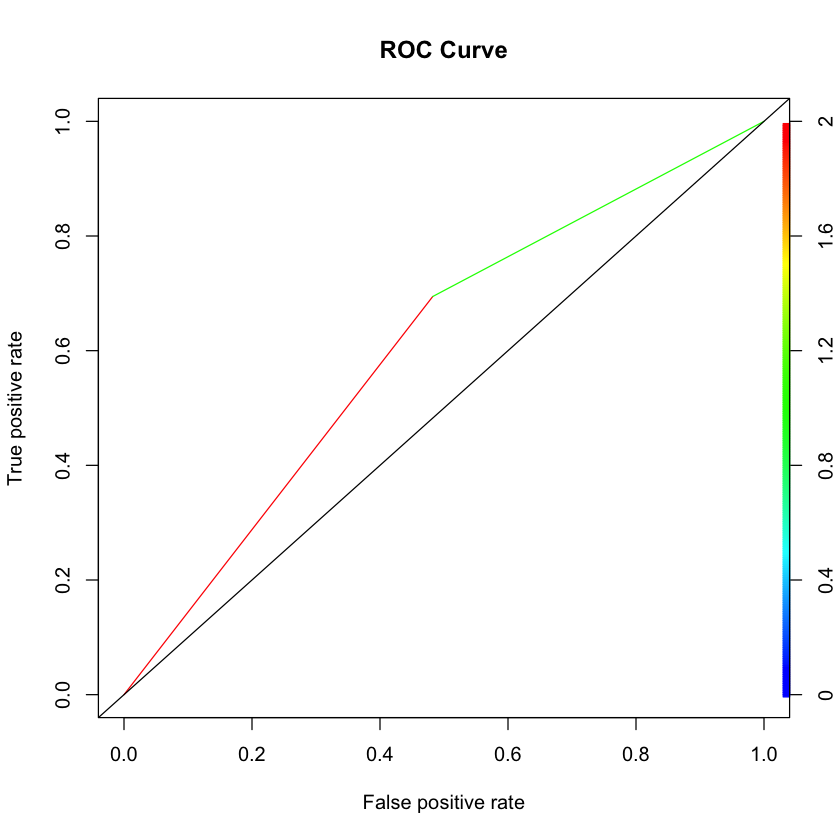

In [7]:
modelPerformance(a549modelSMOTE, "lr", test, Class)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [31]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1082810)$data
table(bothTrain$Class)


     1      0 
541423 541387 

In [32]:
a549modelBoth <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2
+ YY1 ,
               data = bothTrain,
               family = "binomial")
summary(a549modelBoth)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2 + 
    YY1, family = "binomial", data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.9473  -1.1172  -0.8808   1.1873   1.3638  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.3723433  0.0032052 -116.167  < 2e-16 ***
CTCF         0.1280023  0.0027741   46.141  < 2e-16 ***
EP300        0.1050119  0.0034977   30.023  < 2e-16 ***
H3K27me3     0.0615229  0.0021109   29.145  < 2e-16 ***
H3K36me3     0.2021347  0.0026771   75.506  < 2e-16 ***
H3K4me1      0.0737599  0.0011902   61.975  < 2e-16 ***
H3K4me2     -0.0003602  0.0016318   -0.221  0.82528    
H3K4me3     -0.0051108  0.0015546   -3.288  0.00101 ** 
H3K9ac       0.0020645  0.0003861    5.347 8.93e-08 ***
H3K9me3     -0.0954309  0.0021114  -45.198  < 2e-16 ***
RAD21       -0.0546951  0.0029726  -18.400  < 2e-16 ***
RNAPol2     

The confusion matrix is
         Actual
Predicted      0      1
        0    309 327338
        1    317 136193
The misclassification error of the model is 70.59142 % 
The sensitivity of the model is 49.36102 % 
The specificity of the model is 29.38164 % 
The area under curve is 0.3937133 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

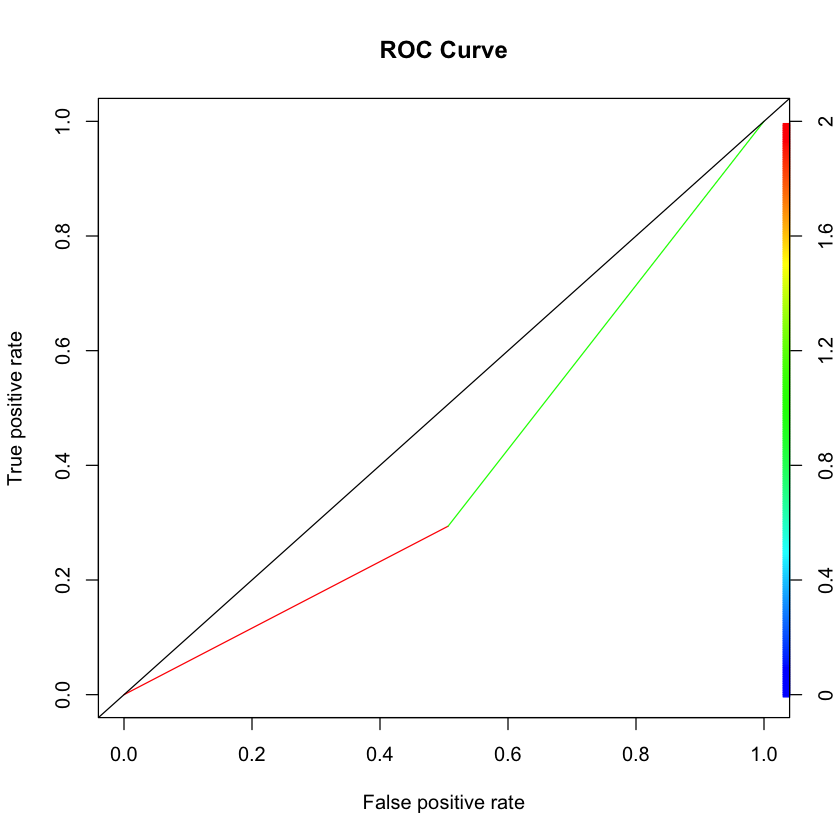

In [33]:
modelPerformance(a549modelBoth, test, test$Class)

These numbers aren't as good. Hitherto, the model with SMOTE data has performed the best.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [34]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(a549greg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- a549greg[parts==1,]
testing <- a549greg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1238782 training rows and 309510 testing rows

In [35]:
a549paretoModel <- glm(formula = Class ~ ., data = training, family = "binomial")
summary(a549paretoModel)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7354   0.0447   0.0474   0.0507   1.7879  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.9587919  0.0358843 193.923  < 2e-16 ***
CTCF        -0.0916857  0.0190454  -4.814 1.48e-06 ***
EP300       -0.0510494  0.0131455  -3.883 0.000103 ***
H3K27me3    -0.0687763  0.0249685  -2.755 0.005878 ** 
H3K36me3    -0.1883406  0.0231468  -8.137 4.06e-16 ***
H3K4me1     -0.0238822  0.0051776  -4.613 3.98e-06 ***
H3K4me2     -0.0218577  0.0138078  -1.583 0.113423    
H3K4me3      0.0024806  0.0127282   0.195 0.845480    
H3K9ac      -0.0046400  0.0023864  -1.944 0.051855 .  
H3K9me3      0.0523695  0.0234842   2.230 0.025748 *  
RAD21        0.0617750  0.0176395   3.502 0.000462 ***
RNAPol2      0.0006401  0.0059480   0.108 0.914305    
YY1         -0.0117983  0.0261201  -0.452 0.651489    
---
Signif. codes:  0 ‘***’ 0.0

The confusion matrix is
         Actual
Predicted      0      1
        0      0      1
        1    626 463530
The misclassification error of the model is 0.1350836 % 
The sensitivity of the model is 0 % 
The specificity of the model is 99.99978 % 
The area under curve is 0.4999989 
The statistical significance for the model is 1.595486e-41 
The confidence level for the model is 100 %

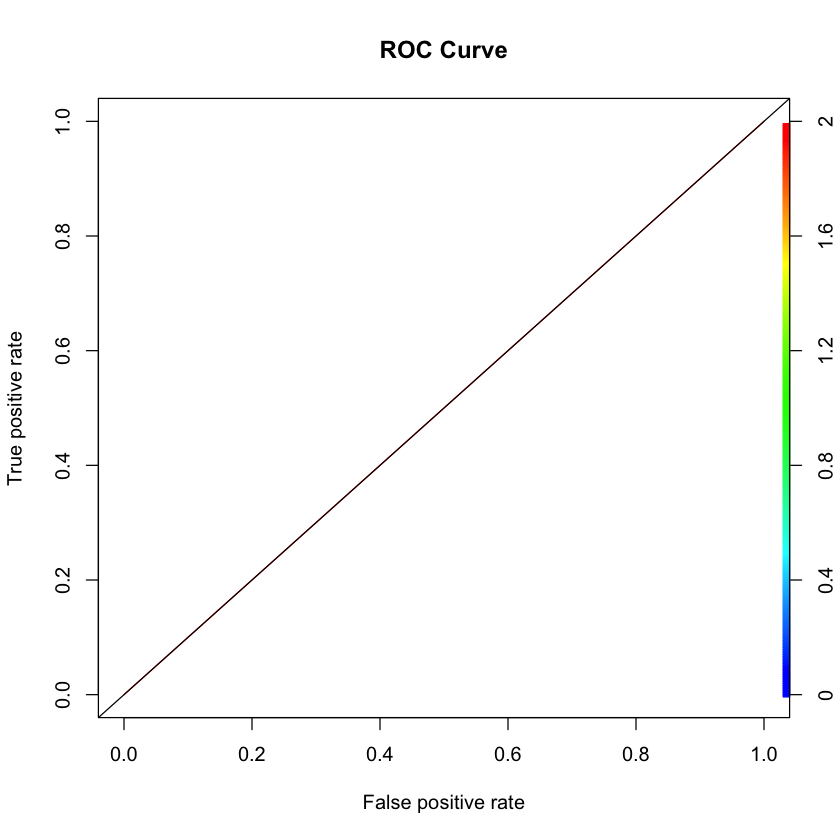

In [36]:
modelPerformance(a549paretoModel, test, test$Class)

We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "1"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [37]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~., training, perc.over = 100000, k = 5, perc.under = 100)
table(smoteDatum$Class)


      0       1 
1538537 1537000 

In [38]:
a549paretoModelSmote <- glm(formula = Class ~ ., data = smoteDatum, family = "binomial")
summary(a549paretoModelSmote)


Call:
glm(formula = Class ~ ., family = "binomial", data = smoteDatum)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4497  -1.1838  -0.2159   1.1108   6.4450  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.4062600  0.0019438  209.005  < 2e-16 ***
CTCF        -0.1107978  0.0017051  -64.981  < 2e-16 ***
EP300       -0.1293084  0.0022420  -57.676  < 2e-16 ***
H3K27me3    -0.0829513  0.0012676  -65.439  < 2e-16 ***
H3K36me3    -0.2533316  0.0016448 -154.024  < 2e-16 ***
H3K4me1     -0.0895072  0.0007138 -125.398  < 2e-16 ***
H3K4me2      0.0266678  0.0010963   24.325  < 2e-16 ***
H3K4me3     -0.0212485  0.0009982  -21.287  < 2e-16 ***
H3K9ac      -0.0004557  0.0002395   -1.903   0.0571 .  
H3K9me3      0.1142932  0.0012627   90.514  < 2e-16 ***
RAD21        0.0517232  0.0017979   28.768  < 2e-16 ***
RNAPol2      0.0028134  0.0004227    6.656 2.81e-11 ***
YY1         -0.0191502  0.0027477   -6.969 3.18e-12 ***
---
Signif. cod

The confusion matrix is
         Actual
Predicted      0      1
        0    187  92251
        1    224 216848
The misclassification error of the model is 29.87787 % 
The sensitivity of the model is 45.49878 % 
The specificity of the model is 70.15487 % 
The area under curve is 0.5782683 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

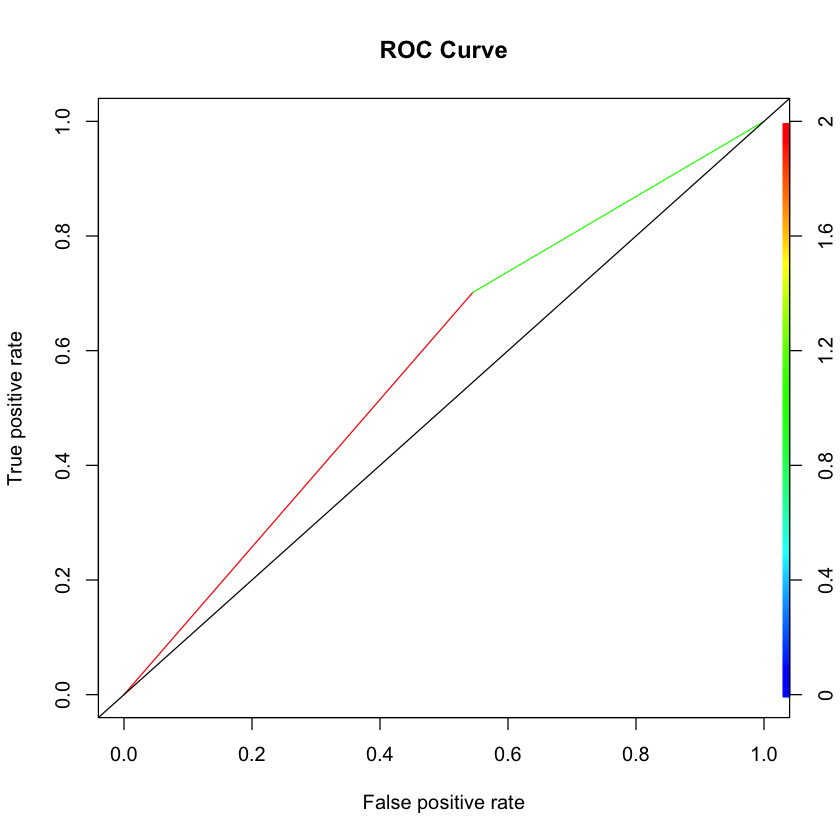

In [39]:
modelPerformance(a549paretoModelSmote, testing, testing$Class)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [30]:
a549gregModelPredictions <- predict(a549modelSMOTE, a549greg, type = "response")
a549gregModelPredictionsProbs <- ifelse(a549gregModelPredictions > 0.5, 1, 0)

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the A549 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz </a> is the package we aim to deploy for visualization.

In [31]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
library(Gviz)

<p align="justify"> Next, we recall the data from the A549 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! </p>

In [32]:
a549gregStandardRegionsClass <- a549gregStandard[, c(1:3,16)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [33]:
# Extracting chr21 data

a549gregChr21NonHub <- a549gregStandardRegionsClass[a549gregStandardRegionsClass$chr=="chr21" & a549gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
a549gregChr21Hub <- a549gregStandardRegionsClass[a549gregStandardRegionsClass$chr=="chr21" & a549gregStandardRegionsClass$Class=="Hub", ]

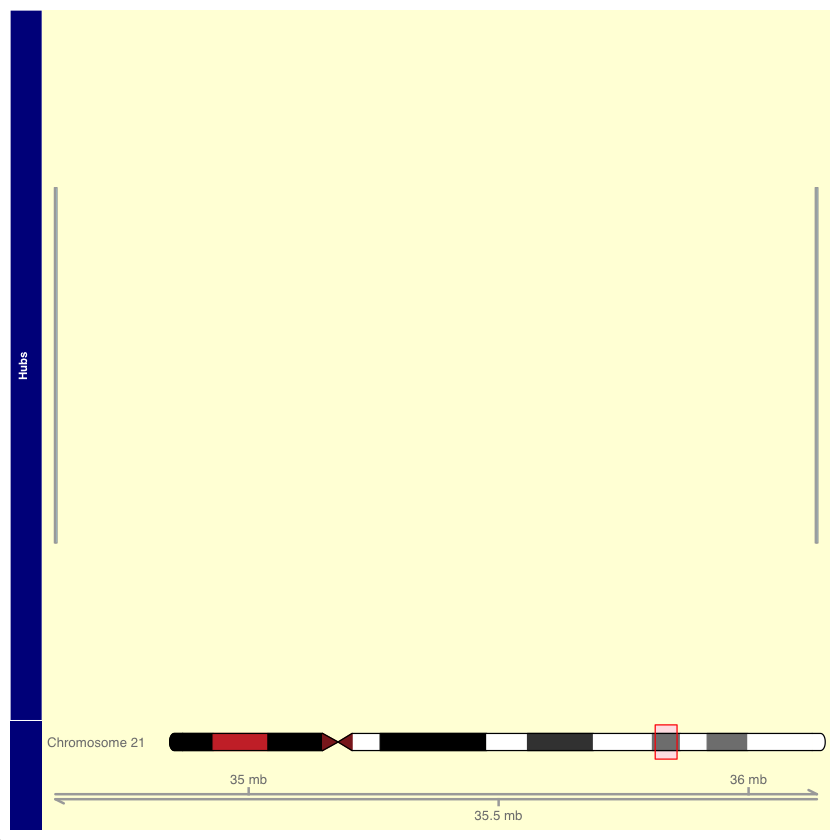

In [15]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = a549gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

In [16]:
print(a549gregChr21Hub)

         chr    start      end Class
814391 chr21 34612001 34614000   Hub
814392 chr21 34614001 34616000   Hub
815152 chr21 36134001 36136000   Hub
815153 chr21 36136001 36138000   Hub


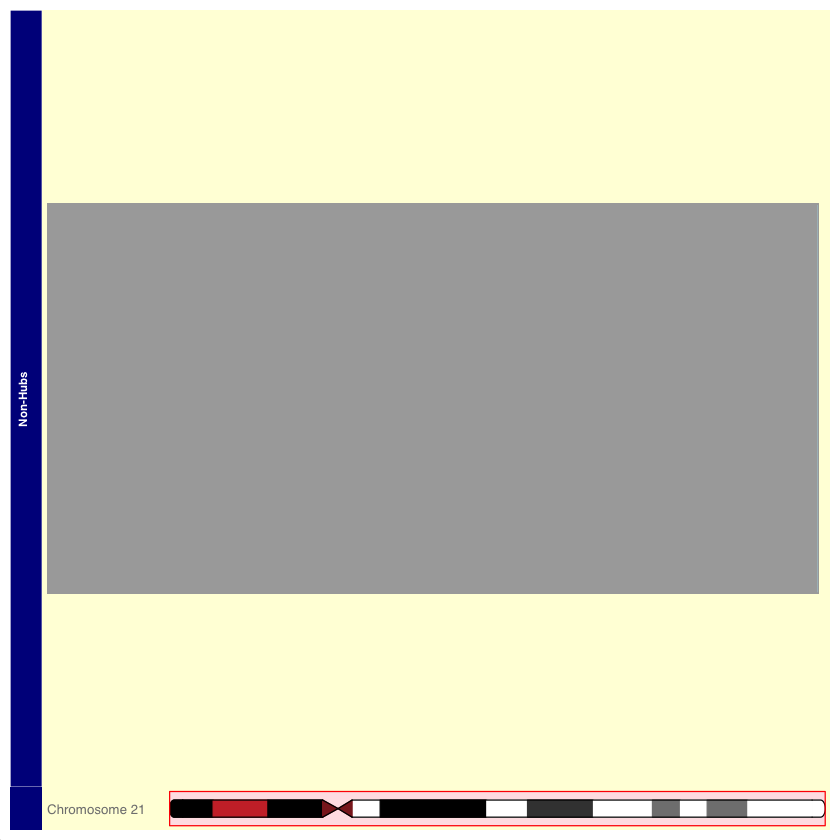

In [17]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = a549gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [34]:
a549gregPredicted <- cbind(a549gregStandardRegionsClass, a549gregModelPredictionsProbs)
names(a549gregPredicted)[names(a549gregPredicted)=="a549gregModelPredictionsProbs"] <- "Prediction"
a549gregPredicted$Prediction <- ifelse(a549gregPredicted$Prediction == 1, "Non-Hub", "Hub")            

Let us see if the classifier predictions match with the original results.

In [35]:
a549gregChr21PredicitedHub <- a549gregPredicted[a549gregPredicted$chr=="chr21" & a549gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

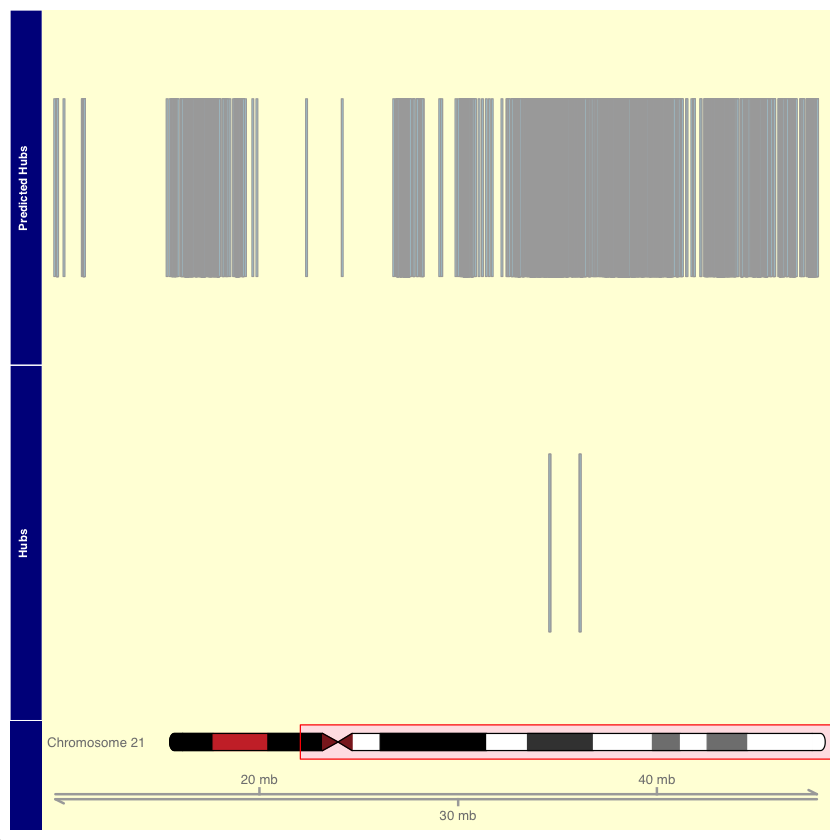

In [20]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = a549gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = a549gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [36]:
truePositives <- a549gregPredicted[a549gregPredicted$Class == a549gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [37]:
save(a549modelSMOTE, file = "./optimalModels/a549modelLR")
write.table(truePositives, file = "./truePositives/a549LR.txt", quote = FALSE)

### <a id=link13>7. Session Information </a>

In [50]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.32.0          GenomicRanges_1.40.0 GenomeInfoDb_1.24.2 
 [4] IRanges_2.22.2       S4Vectors_0.26.1     BiocGenerics_0.34.0 
 [7] ROCR_1.0-11          DMwR_0.4.1           ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         Hmisc_4.4-1          ggplot2_3.3.2       
[16] Formula_1.2-3        survival_3.2-3       lattice_0.20-41     
[19] glmnet_4.0-2         Matrix_1.2-18       

loaded via a namespace (and not attached):
  [1] uui